1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [8]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_name = "./data/data_000637.txt"
N=15000
data = pd.read_csv(file_name, nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
14995,1,1,4,3869200316,3399,9
14996,1,1,17,3869200316,3400,15
14997,1,1,10,3869200316,3530,16
14998,1,1,8,3869200316,3533,18


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [10]:
bx = data["BX_COUNTER"]
bx
print("Number of max", max(bx) + 1)

Number of max 3564


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [11]:
data['ABS_TIME']  = data.apply(lambda row: (row.ORBIT_CNT)*bx.max()*25 + (row.BX_COUNTER)*25 + (row.TDC_MEAS)*25/30, axis=1)
#df['ABS_TIME'] = df['ABS_TIME'].astype('datetime64[ns]')
data['ABS_TIME'] = pd.to_datetime(data['ABS_TIME'])
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,1970-01-04 23:44:09.004934896
1,1,0,124,3869200167,2374,27,1970-01-04 23:44:09.004934897
2,1,0,63,3869200167,2553,28,1970-01-04 23:44:09.004939373
3,1,0,64,3869200167,2558,19,1970-01-04 23:44:09.004939490
4,1,0,64,3869200167,2760,25,1970-01-04 23:44:09.004944545
...,...,...,...,...,...,...,...
14995,1,1,4,3869200316,3399,9,1970-01-04 23:44:09.018232682
14996,1,1,17,3869200316,3400,15,1970-01-04 23:44:09.018232712
14997,1,1,10,3869200316,3530,16,1970-01-04 23:44:09.018235963
14998,1,1,8,3869200316,3533,18,1970-01-04 23:44:09.018236040


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [12]:
data2 = pd.read_csv("./data/data_000637.txt", sep=",")

abc=data2["BX_COUNTER"].max()
data2['ABS_TIME'] = data2.apply(lambda row: (row.ORBIT_CNT)*abc*25 + (row.BX_COUNTER)*25 + (row.TDC_MEAS)*25/30, axis=1)
data2['ABS_TIME'] = pd.to_timedelta(data2['ABS_TIME'])
data2.head(10)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,3 days 23:44:09.004934896
1,1,0,124,3869200167,2374,27,3 days 23:44:09.004934897
2,1,0,63,3869200167,2553,28,3 days 23:44:09.004939373
3,1,0,64,3869200167,2558,19,3 days 23:44:09.004939490
4,1,0,64,3869200167,2760,25,3 days 23:44:09.004944545
5,1,0,63,3869200167,2762,4,3 days 23:44:09.004944578
6,1,0,61,3869200167,2772,14,3 days 23:44:09.004944836
7,1,0,139,3869200167,2776,0,3 days 23:44:09.004944925
8,1,0,62,3869200167,2774,21,3 days 23:44:09.004944892
9,1,0,60,3869200167,2788,7,3 days 23:44:09.004945230


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [13]:
a = data.groupby(by='TDC_CHANNEL', sort=True).count()
a = a.sort_values('HEAD', ascending=False)
print("List of top 3 most noisy TDC_CHANNELS: ", [x for x in a.index[0:3]])

List of top 3 most noisy TDC_CHANNELS:  [139, 64, 63]


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [14]:
count_nempty = 0
for i in range(data['ORBIT_CNT'][0], data['ORBIT_CNT'][14999]):
    if i in list(zip(*data.values.tolist()))[3]:
        count_nempty+=1
        a = data.loc[(data['ORBIT_CNT'] == i)]
        
        
print("Number of non-empty orbits: ",count_nempty)

Number of non-empty orbits:  149


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [15]:
count_nempty = 0
count_fromtdc =0
for i in range(data['ORBIT_CNT'][0], data['ORBIT_CNT'][14999]):
    if i in list(zip(*data.values.tolist()))[3]:
        count_nempty+=1
        a = data.loc[(data['ORBIT_CNT'] == i) & (data['TDC_CHANNEL']==139)]
        if not a.empty: 
            count_fromtdc += 1
        
print("Number of non-empty orbits with at least one measurement from TDC_CHANNEL=139: ",count_fromtdc)

Number of non-empty orbits with at least one measurement from TDC_CHANNEL=139:  149


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [16]:
fpga_0 = pd.Series(data[data['FPGA']==0]['TDC_CHANNEL'].value_counts()) ##selecting FPGA with number 0 and counting each instance of TDC_CHANNEL value
fpga_1 = pd.Series(data[data['FPGA']==1]['TDC_CHANNEL'].value_counts()) ##selecting FPGA with number 1 and counting each instance of TDC_CHANNEL value
print("The FPGA identified with 0:\n", fpga_0)

The FPGA identified with 0:
 139    879
63     743
64     735
61     555
62     529
      ... 
99       5
107      5
98       5
106      4
101      3
Name: TDC_CHANNEL, Length: 117, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0, 0.5, 'Count')

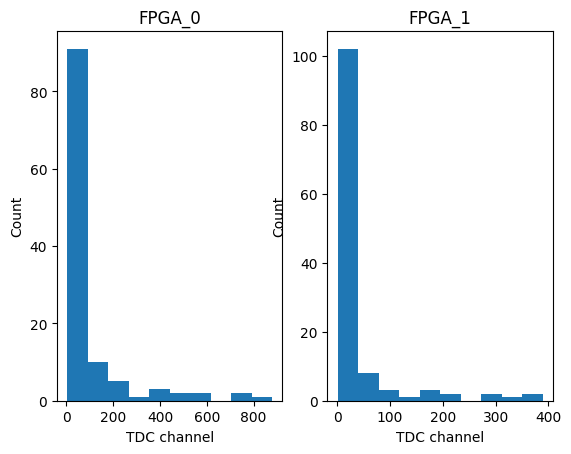

In [17]:
a = data.groupby('TDC_CHANNEL').count()['FPGA']
fig, (ax1, ax2, ) = plt.subplots(1, 2,)

ax1.hist(fpga_0) ##create histogtram
ax1.set_title('FPGA_0')
ax1.set_xlabel('TDC channel')
ax1.set_ylabel('Count')

ax2.hist(fpga_1)
ax2.set_title('FPGA_1')
ax2.set_xlabel('TDC channel')
ax2.set_ylabel('Count')